In [43]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install webrtcvad --user

  Cache entry deserialization failed, entry ignored
  Cache entry deserialization failed, entry ignored
    100% |████████████████████████████████| 71kB 863kB/s ta 0:00:01
  Running setup.py bdist_wheel for webrtcvad ... done
  Stored in directory: /home/mpc6/.cache/pip/wheels/44/2a/18/bd1aec41cac7c3051fe95d92a6ed446122ea31dc713c432fa1
Successfully built webrtcvad
You are using pip version 9.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [12]:
import os, sys
import soundfile as sf
#import sounddevice as sd
#import librosa
import numpy as np
import glob
import matplotlib.pyplot as plt
from IPython.display import Audio
import thinkdsp
import subprocess
from subprocess import Popen, PIPE
#from sklearn.model_selection import train_test_split
#import pickle
# Keras packages model
#from keras.models import Sequential, Model, load_model
#from keras.layers import Input, Reshape, Dense, GRU, Convolution1D, Convolution2D, MaxPooling1D, MaxPooling2D, Dropout, BatchNormalization, Flatten, concatenate 
#from keras.callbacks import Callback, ModelCheckpoint, CSVLogger, EarlyStopping
#from keras import regularizers

SAMPLERATE = 8000
DATAPATH = 'data/test'


In [ ]:
# Download raw data from source
#os.environ['PYTHONUNBUFFERED'] = 'True'

os.makedirs(DATAPATH, exist_ok=True)

url = 'http://download.tensorflow.org/data/'
file_name = 'speech_commands_v0.01.tar.gz'

if not os.path.exists(DATAPATH):
    os.makdirs(DATAPATH)
        
if not os.path.exists(os.path.join(DATAPATH, file_name)):
    
    print('Downloading', file_name)
    rtnVal = subprocess.call(['wget', os.path.join(url,file_name), '-P', DATAPATH])
    assert rtnVal == 0, 'downloaded failed!'
    print(file_name, 'downloaded successfully')
    
    print('Uncompressing', os.path.basename(data_file))
    rtnVal = subprocess.call(['tar', '-zxvf', os.path.basename(data_file)])
    assert rtnVal == 0, 'file failed to uncompress!'
    print(file_name, 'uncompressed successfully')



In [31]:
# Pre-process the data
def get_averages(samples, frameSize):
    averages = []
    for frame in range(0,len(samples), frameSize):
        averages.append(np.average(np.absolute(samples[frame:frame+frameSize])))

    return averages

def find_clusters(samples, averages, target, frameSize):
    startIdx = None
    endIdx = None
    clusters = []
    for idx, frame in enumerate(range(0,len(samples), frameSize)):
        #print('frame avg:', averages[idx])
        if averages[idx] > target and not startIdx:
            startIdx = idx
        if startIdx and not endIdx:
            if averages[idx] < target:
                endIdx = idx
        if startIdx and endIdx:
            clusters.append((startIdx,endIdx))
            startIdx = None
            endIdx = None

    # incase last frame is above average
    if startIdx != None and endIdx == None:
        endIdx = idx
        clusters.append((startIdx,endIdx))
        
    #print(averages[idx])
    return clusters

def find_longest_cluster(clusters):
    longestCluster = 0
    longestClusterSize = 0
    for cluster in clusters:
        clusterSize = cluster[1]-cluster[0]
        if clusterSize > longestClusterSize:
            longestClusterSize = clusterSize
            longestCluster = cluster

    return longestCluster

def clip_audio(samples):

    frameSize = 100
    averages = get_averages(samples, frameSize)
    target = np.average(averages)/2     # threshold, assume below this level is backround noise

    #print('target avg:', target)
    # find all audio clusters above target threshold
    clusters = find_clusters(samples, averages, target, frameSize)

    #for cluster in clusters:
    #    print(cluster[0]*frameSize, cluster[1]*frameSize)
    #print('Clusters:', clusters)
    
    # find longest audio cluster
    longestCluster = find_longest_cluster(clusters)
    
    print('Clipping samples', longestCluster[0]*frameSize, longestCluster[1]*frameSize)

    return samples[longestCluster[0]*frameSize:longestCluster[1]*frameSize+frameSize]

def clip_audio2(samples):
    maxEnergy = np.argmax(samples)
    return samples[maxEnergy-(SAMPLERATE//2):maxEnergy+(SAMPLERATE//2)]

def clip_waves(rawAudioPath, clippedAudioPath, frameSize):
    os.makedirs(clippedAudioPath, exist_ok=True)
    for fileName in glob.iglob(os.path.join(rawAudioPath, '*.wav')):
        print('File:', fileName)
        samples, sample_rate = sf.read(fileName )
        print("number of samples:", len(samples))

        # find largest cluster of audio and grab the samples
        #clippedSamples = clip_audio(samples)
        clippedSamples = clip_audio2(samples)
        #frameSize = 5120
        #clippedSamples = highest_energy_frame(samples, frameSize)

        # write clipped audio to file
        clippedFileName = os.path.join(clippedAudioPath, os.path.basename(fileName))
        sf.write(clippedFileName, clippedSamples, SAMPLERATE, subtype='PCM_16')
        print(fileName,' clipped and saved as ',clippedFileName)
        
def filter_audio(audioPath, outAudioPath, highCutoff, lowCutoff):
    print('Filter files in', audioPath, 'and saving to', outAudioPath)
    for fileName in glob.iglob(os.path.join(audioPath, '*.wav')):
        print('File:', fileName)
        sample = thinkdsp.read_wave(fileName)
        spectrum = sample.make_spectrum()
        spectrum.low_pass(cutoff=highCutoff, factor=0.01)
        spectrum.high_pass(cutoff=lowCutoff, factor=0.01)
        wave = spectrum.make_wave()
        outFileName = os.path.join(outAudioPath, os.path.basename(fileName))
        wave.play(outFileName)
    print('Filtering complete!')
    

vadScript = 'vad_wavs.py'
dataDir = 'numbers'
agressiveness = '3'
numbersDir = os.path.join(DATAPATH, dataDir)
filteredDir = os.path.join(DATAPATH, 'flt_numbers_test')
trainingDir = os.path.join(DATAPATH, 'tst_numbers_test2')
os.makedirs(filteredDir, exist_ok=True)
os.makedirs(trainingDir, exist_ok=True)

# High and low pass filter
highCutoff = 3400
lowCutoff = 300
#filter_audio(numbersDir, filteredDir, highCutoff, lowCutoff)
frameSize = 8000
# Saves voice from raw data
print('Saving voice activity from waves')
#rtnVal = subprocess.call(['python', vadScript, agressiveness, filteredDir, trainingDir])
clip_waves(filteredDir, trainingDir, frameSize)
print('Finished saving voice activity')



Saving voice activity from waves
File: data/flt_numbers_test/006a5b2cb6.wav
number of samples: 16384
data/flt_numbers_test/006a5b2cb6.wav  clipped and saved as  data/tst_numbers_test2/006a5b2cb6.wav
File: data/flt_numbers_test/0130bbb543.wav
number of samples: 12308
data/flt_numbers_test/0130bbb543.wav  clipped and saved as  data/tst_numbers_test2/0130bbb543.wav
File: data/flt_numbers_test/0217a3b12a.wav
number of samples: 16346
data/flt_numbers_test/0217a3b12a.wav  clipped and saved as  data/tst_numbers_test2/0217a3b12a.wav
File: data/flt_numbers_test/029830a064.wav
number of samples: 15702
data/flt_numbers_test/029830a064.wav  clipped and saved as  data/tst_numbers_test2/029830a064.wav
File: data/flt_numbers_test/099743a386.wav
number of samples: 15604
data/flt_numbers_test/099743a386.wav  clipped and saved as  data/tst_numbers_test2/099743a386.wav
File: data/flt_numbers_test/0c7156ca20.wav
number of samples: 15702
data/flt_numbers_test/0c7156ca20.wav  clipped and saved as  data/tst_

number of samples: 16346
data/flt_numbers_test/7a7651cca1.wav  clipped and saved as  data/tst_numbers_test2/7a7651cca1.wav
File: data/flt_numbers_test/7c18516800.wav
number of samples: 16346
data/flt_numbers_test/7c18516800.wav  clipped and saved as  data/tst_numbers_test2/7c18516800.wav
File: data/flt_numbers_test/7c2194c226.wav
number of samples: 15702
data/flt_numbers_test/7c2194c226.wav  clipped and saved as  data/tst_numbers_test2/7c2194c226.wav
File: data/flt_numbers_test/7c70962c75.wav
number of samples: 16346
data/flt_numbers_test/7c70962c75.wav  clipped and saved as  data/tst_numbers_test2/7c70962c75.wav
File: data/flt_numbers_test/8071571c06.wav
number of samples: 8322
data/flt_numbers_test/8071571c06.wav  clipped and saved as  data/tst_numbers_test2/8071571c06.wav
File: data/flt_numbers_test/891779c374.wav
number of samples: 15702
data/flt_numbers_test/891779c374.wav  clipped and saved as  data/tst_numbers_test2/891779c374.wav
File: data/flt_numbers_test/89b5682636.wav
numbe

In [3]:
def highest_energy_frame(data, frameSize):
    numFrames = len(data)//frameSize
    largestEnergy = 0
    largestWindow = 0
    stepSize = 100
    
    for window in np.arange(0,len(data)-frameSize, stepSize):
        #startWindow = frame*frameSize
        currEnergy = np.sum(np.absolute(np.array(data[window:window+frameSize])))
        #print(window, ':', currEnergy)
        if currEnergy > largestEnergy:
            largestWindow = window
            largestEnergy = currEnergy
    
   # print('Largest Window Start:', largestWindow)
    return data[largestWindow:largestWindow+frameSize]

#print(len(data))
#
#print(np.arange(0,len(data)-frameSize, stepSize))
    

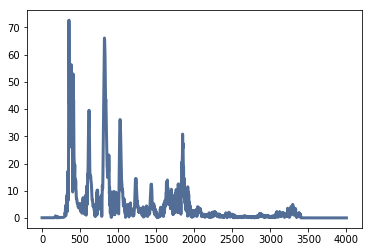

In [30]:
#Examine a wave's spectrum
#waveFile = 'data/trainingNums/05_620a81c69b-VAD.wav'
waveFile = 'data/tst_numbers_test/2581723976.wav'
sample = thinkdsp.read_wave(waveFile)
spectrum = sample.make_spectrum()
#spectrum.low_pass(cutoff=3400, factor=0.01)
#spectrum.high_pass(cutoff=300, factor=0.01)
spectrum.plot()

In [71]:
# Dataset creation functions

def get_longest_samples(dataPath):
    longestNumSamples = 0
    shortestNumSamples = 16000

    numSamples = []
    #print('Finding longest wave file')
    for fileName in glob.iglob(os.path.join(dataPath, '*.wav')):
        #print('File:', fileName)
        data, sr = sf.read(fileName)
        if len(data) > MINSIZE and len(data) < MAXSIZE:
            numSamples.append(len(data))
        assert sr == SAMPLERATE, 'wave file is not correct sample rate!'
        if len(data) < shortestNumSamples and len(data) > MINSIZE:
            shortestNumSamples = len(data)
            #print('File:', fileName, shortestNumSamples)
        if len(data) > longestNumSamples and len(data) < MAXSIZE:
            longestNumSamples = len(data)
            #print('File:', fileName, longestNumSamples)

    print('Number of examples:', len(numSamples))
#    numSmallSamples = 0
#    numLargeSamples = 0
#    for num in numSamples:
#        if num < 2*frameSize:
#            numSmallSamples += 1
#            print(num)
#        if num > 8000:
#            numLargeSamples += 1
#            print(num)

#    print('Longest sample = ', longestNumSamples, numLargeSamples, '/', len(numSamples))
#    print('Shortest sample = ', shortestNumSamples, numSmallSamples, '/', len(numSamples))
    return longestNumSamples

def get_frame_magnitudes(samples, numFrames, frameSize, overlap, window):
    magnitudes = np.empty((0,frameSize//2 +1))
    #print(len(samples), frameSize, overlap)
    for frame in range(numFrames):
        frameStart = frame * frameSize - frame * overlap
        # start overlap after first frame
        #if frameStart > 0:
        #    frameStart -= overlap
        #print('FrameStart:',frameStart)
        data = samples[frameStart:frameStart+frameSize]
        #print(len(data), len(window))
        frameMags = np.fft.rfft(window*data)
        #print(frameMags.shape)
        magnitudes = np.vstack((magnitudes, np.real(np.fft.rfft(window*data))))
        
    #print(magnitudes.shape)
    return magnitudes

def build_dataset(dataPath, numFrames, numSamples):
    print('building dataset')
    longestNumSamples = get_longest_samples(dataPath)
    frameSize = longestNumSamples//numFrames
    frameSize = numSamples//numFrames
    #print('frame size =', frameSize)
    window = np.hanning(frameSize)
    trainingData = []
    trainingTargets = []
    #print('getting magnitudes')
    for fileName in glob.iglob(os.path.join(dataPath, '*.wav')):
        #print('File:', fileName)
        data, sr = sf.read(fileName)
        #print(len(data))
        #if MINSIZE < len(data) < MAXSIZE:
        if len(data) == numSamples:
        #if True:
            #print(len(data))
            overlap = ((frameSize * numFrames - len(data))//(numFrames - 1)) + 1
            #overlap = 0
            #trainingData = np.vstack((trainingData, get_frame_magnitudes(data, numFrames, frameSize, overlap, window)))
            trainingData.append(get_frame_magnitudes(data, numFrames, frameSize, overlap, window))
            trainingTargets.append(os.path.basename(fileName).split('_')[0])
        
    return trainingData, trainingTargets, frameSize

def get_training_data(dataPath, numFrames, numSamples):
    x_train, y_train, frameSize = build_dataset(dataPath, numFrames, numSamples)
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    print('Frame Size:', frameSize)
    print('Num Examples:', x_train.shape[0])
    #print('Training Targets:', y_train)
    return x_train, y_train, frameSize



In [5]:
# Model definitions
def model_dense(batchSize, numNeurons, outputs, numFrames, freqBins):
    regVal = 0.0001
    x_in = Input(batch_shape=(None, numFrames, freqBins))
    x = Dense(numNeurons, activation='relu', kernel_regularizer=regularizers.l2(regVal), bias_regularizer=regularizers.l2(regVal))(x_in)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(numNeurons, activation='relu', kernel_regularizer=regularizers.l2(regVal), bias_regularizer=regularizers.l2(regVal))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(numNeurons, activation='relu', kernel_regularizer=regularizers.l2(regVal), bias_regularizer=regularizers.l2(regVal))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Flatten()(x)   
    x = Dense(numNeurons, activation='relu', kernel_regularizer=regularizers.l2(regVal), bias_regularizer=regularizers.l2(regVal))(x)
    x = Dense(outputs, activation='softmax', kernel_regularizer=regularizers.l2(regVal), bias_regularizer=regularizers.l2(regVal))(x)
    model = Model(inputs=[x_in], outputs=[x])
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def model_conv(batchSize, numNeurons, outputs, numFrames, freqBins):
    regVal = 0
    x_in = Input(batch_shape=(None, numFrames, freqBins))
    x = Convolution1D(128, 2, activation='relu', padding='same', kernel_regularizer=regularizers.l2(regVal), bias_regularizer=regularizers.l2(regVal))(x_in)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
#    x = Reshape(( numFrames, 128, 1))(x)
#    x = MaxPooling2D(pool_size=(1,2))(x)
#    x = Reshape((numFrames,64))(x)
    x = Convolution1D(64, 2, activation='relu', padding='same', kernel_regularizer=regularizers.l2(regVal), bias_regularizer=regularizers.l2(regVal))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
#    x = Reshape(( numFrames, 64, 1))(x)
#    x = MaxPooling2D(pool_size=(1,2))(x)
#    x = Reshape((numFrames,32))(x)
    x = Convolution1D(32, 2, activation='relu', padding='same', kernel_regularizer=regularizers.l2(regVal), bias_regularizer=regularizers.l2(regVal))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
#    x = Reshape(( numFrames, 32, 1))(x)
#    x = MaxPooling2D(pool_size=(1,2))(x)
    x = Flatten()(x)
    x = Dense(numNeurons, activation='relu')(x)
    x = Dense(outputs, activation='softmax', kernel_regularizer=regularizers.l2(regVal), bias_regularizer=regularizers.l2(regVal))(x)
    model = Model(inputs=[x_in], outputs=[x])
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def model_rnn(batchSize, numNeurons, outputs, numFrames, freqBins):
    regVal = 0.0001
    x_in = Input(batch_shape=(None, numFrames, freqBins))
    x = Dense(numNeurons, activation='relu', kernel_regularizer=regularizers.l2(regVal), bias_regularizer=regularizers.l2(regVal))(x_in)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = GRU(numNeurons, activation='relu', return_sequences=True, stateful=False, kernel_regularizer=regularizers.l2(regVal), bias_regularizer=regularizers.l2(regVal))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = GRU(numNeurons, activation='relu', return_sequences=False, stateful=False, kernel_regularizer=regularizers.l2(regVal), bias_regularizer=regularizers.l2(regVal))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
#    x = Flatten()(x) 
    x = Dense(numNeurons, activation='relu')(x)
    x = Dense(outputs, activation='softmax', kernel_regularizer=regularizers.l2(regVal), bias_regularizer=regularizers.l2(regVal))(x)
    model = Model(inputs=[x_in], outputs=[x])
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [75]:
# Main Program
dataPath = 'data/trainingNums2'
numFrames = 15
numSamples = 8000

x_train, y_train, frameSize = get_training_data(dataPath, numFrames, numSamples)

batchSize = 16
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.05, shuffle=True )
#numTrainExamples = batchSize * (len(x_train)//batchSize)
#x_train = x_train[0:numTrainExamples,:,:]
#y_train = y_train[0:numTrainExamples]
#numValidExamples = batchSize * (len(x_valid)//batchSize)
#x_valid = x_valid[0:numValidExamples,:,:]
#y_valid = y_valid[0:numValidExamples]
#print('Training on', numTrainExamples, 'examples')
#print('Validating on', numValidExamples, 'examples')

freqBins = frameSize//2 + 1
epochs = 500
numNeurons = 256
outputs = 13 # 0-12
# model_dense for FCN, model_conv for convolutional, model_rnn for recurrent
AudioWords = model_dense(batchSize, numNeurons, outputs, numFrames, freqBins)
AudioWords.summary()

modelFile = 'AudioWords.h5'
bestModelCheckpoint = ModelCheckpoint(modelFile, save_best_only=True)

model_history = AudioWords.fit(x_train, y_train, validation_data=(x_valid, y_valid), batch_size=batchSize, epochs=epochs, callbacks=[bestModelCheckpoint])
with open(modelFile.replace('.h5', '.npy'), "wb") as outfile:
    pickle.dump(model_history.history, outfile)

building dataset
Number of examples: 0
Frame Size: 533
Num Examples: 571
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 15, 267)           0         
_________________________________________________________________
dense_55 (Dense)             (None, 15, 256)           68608     
_________________________________________________________________
batch_normalization_37 (Batc (None, 15, 256)           1024      
_________________________________________________________________
dropout_37 (Dropout)         (None, 15, 256)           0         
_________________________________________________________________
dense_56 (Dense)             (None, 15, 256)           65792     
_________________________________________________________________
batch_normalization_38 (Batc (None, 15, 256)           1024      
_________________________________________________________________
dro

Epoch 46/500
542/542 [==============================] - 1s 2ms/step - loss: 0.2830 - acc: 0.9686 - val_loss: 3.6869 - val_acc: 0.3448
Epoch 47/500
542/542 [==============================] - 1s 2ms/step - loss: 0.2825 - acc: 0.9668 - val_loss: 4.2166 - val_acc: 0.3793
Epoch 48/500
542/542 [==============================] - 1s 2ms/step - loss: 0.2824 - acc: 0.9613 - val_loss: 4.3216 - val_acc: 0.3103
Epoch 49/500
542/542 [==============================] - 1s 2ms/step - loss: 0.2678 - acc: 0.9705 - val_loss: 4.5714 - val_acc: 0.3103
Epoch 50/500
542/542 [==============================] - 1s 2ms/step - loss: 0.2692 - acc: 0.9760 - val_loss: 5.1990 - val_acc: 0.3448
Epoch 51/500
542/542 [==============================] - 1s 2ms/step - loss: 0.3230 - acc: 0.9539 - val_loss: 4.0007 - val_acc: 0.4828
Epoch 52/500
542/542 [==============================] - 1s 2ms/step - loss: 0.3061 - acc: 0.9668 - val_loss: 3.8348 - val_acc: 0.5172
Epoch 53/500
542/542 [==============================] - 1s 2ms

542/542 [==============================] - 1s 2ms/step - loss: 0.3270 - acc: 0.9742 - val_loss: 4.2056 - val_acc: 0.4138
Epoch 108/500
542/542 [==============================] - 1s 2ms/step - loss: 0.3287 - acc: 0.9779 - val_loss: 4.7566 - val_acc: 0.3793
Epoch 109/500
542/542 [==============================] - 1s 2ms/step - loss: 0.3806 - acc: 0.9686 - val_loss: 4.1033 - val_acc: 0.3793
Epoch 110/500
542/542 [==============================] - 1s 2ms/step - loss: 0.3086 - acc: 0.9779 - val_loss: 3.9336 - val_acc: 0.4138
Epoch 111/500
542/542 [==============================] - 1s 2ms/step - loss: 0.3161 - acc: 0.9742 - val_loss: 3.8932 - val_acc: 0.4828
Epoch 112/500
542/542 [==============================] - 1s 2ms/step - loss: 0.3182 - acc: 0.9779 - val_loss: 3.7853 - val_acc: 0.3793
Epoch 113/500
542/542 [==============================] - 1s 2ms/step - loss: 0.2709 - acc: 0.9908 - val_loss: 4.2445 - val_acc: 0.3793
Epoch 114/500
542/542 [==============================] - 1s 2ms/step 

Epoch 168/500
542/542 [==============================] - 1s 2ms/step - loss: 0.3533 - acc: 0.9797 - val_loss: 5.0802 - val_acc: 0.3793
Epoch 169/500
542/542 [==============================] - 1s 2ms/step - loss: 0.3825 - acc: 0.9742 - val_loss: 4.8604 - val_acc: 0.4828
Epoch 170/500
542/542 [==============================] - 1s 2ms/step - loss: 0.3818 - acc: 0.9760 - val_loss: 5.0243 - val_acc: 0.3793
Epoch 171/500
542/542 [==============================] - 1s 2ms/step - loss: 0.3833 - acc: 0.9797 - val_loss: 4.7035 - val_acc: 0.4138
Epoch 172/500
542/542 [==============================] - 1s 2ms/step - loss: 0.4314 - acc: 0.9686 - val_loss: 5.0869 - val_acc: 0.3793
Epoch 173/500
542/542 [==============================] - 1s 2ms/step - loss: 0.4057 - acc: 0.9742 - val_loss: 4.8505 - val_acc: 0.4138
Epoch 174/500
542/542 [==============================] - 1s 2ms/step - loss: 0.4398 - acc: 0.9705 - val_loss: 5.2405 - val_acc: 0.3793
Epoch 175/500
542/542 [==============================] 

Epoch 289/500
542/542 [==============================] - 1s 2ms/step - loss: 0.3902 - acc: 0.9926 - val_loss: 4.9012 - val_acc: 0.4483
Epoch 290/500
542/542 [==============================] - 1s 2ms/step - loss: 0.3813 - acc: 0.9926 - val_loss: 5.0834 - val_acc: 0.4483
Epoch 291/500
542/542 [==============================] - 1s 2ms/step - loss: 0.3597 - acc: 0.9963 - val_loss: 5.1498 - val_acc: 0.4483
Epoch 292/500
542/542 [==============================] - 1s 2ms/step - loss: 0.3780 - acc: 0.9871 - val_loss: 5.0907 - val_acc: 0.3793
Epoch 293/500
542/542 [==============================] - 1s 2ms/step - loss: 0.4050 - acc: 0.9889 - val_loss: 5.8106 - val_acc: 0.3448
Epoch 294/500
542/542 [==============================] - 1s 2ms/step - loss: 0.3827 - acc: 0.9945 - val_loss: 5.7318 - val_acc: 0.3103
Epoch 295/500
542/542 [==============================] - 1s 2ms/step - loss: 0.3783 - acc: 0.9908 - val_loss: 5.6425 - val_acc: 0.3448
Epoch 296/500
542/542 [==============================] 

KeyboardInterrupt: 

In [69]:
# evaluate model on test data
modelFile = 'save_models2-5/AudioWords.h5'
#modelFile = 'save_models-5/AudioWords.h5'
dataPath = 'data/tst_numbers_test'
numFrames = 5
numSamples = 8000

x_train, _, _ = get_training_data(dataPath, numFrames, numSamples)

AudioWords = load_model(modelFile)
AudioWords.summary()
outs = AudioWords.predict(x_train)

preds = [np.argmax(out) for out in outs]
print(preds)
csvData = []
for fileName, pred in zip(glob.iglob(os.path.join(dataPath, '*.wav')), preds):
        #print('File:', fileName)
        out = [pred, fileName]
        print(out)
        csvData.append(out)
        

building dataset
Number of examples: 83
File: data/tst_numbers_test/006a5b2cb6.wav
File: data/tst_numbers_test/0130bbb543.wav
File: data/tst_numbers_test/0217a3b12a.wav
File: data/tst_numbers_test/029830a064.wav
File: data/tst_numbers_test/099743a386.wav
File: data/tst_numbers_test/0c7156ca20.wav
File: data/tst_numbers_test/135451ab23.wav
File: data/tst_numbers_test/1510c30707.wav
File: data/tst_numbers_test/16ac11144b.wav
File: data/tst_numbers_test/17b6a64673.wav
File: data/tst_numbers_test/1aa7222c02.wav
File: data/tst_numbers_test/2581723976.wav
File: data/tst_numbers_test/2885430727.wav
File: data/tst_numbers_test/2918750a33.wav
File: data/tst_numbers_test/298a616a81.wav
File: data/tst_numbers_test/2aa949c3a3.wav
File: data/tst_numbers_test/2b9c815b22.wav
File: data/tst_numbers_test/2c2caacb08.wav
File: data/tst_numbers_test/2ccc498b11.wav
File: data/tst_numbers_test/349a432075.wav
File: data/tst_numbers_test/3511193c15.wav
File: data/tst_numbers_test/3720059427.wav
File: data/tst

8000
8000


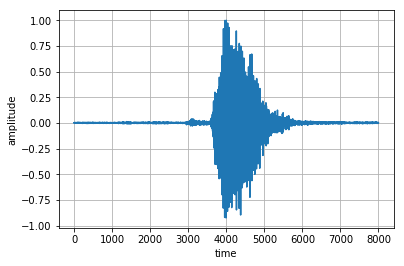

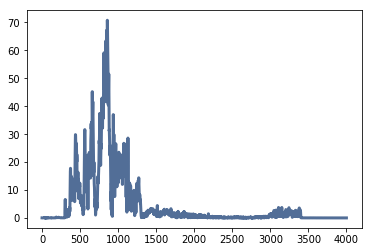

In [84]:
# load a wave, plot and play
fileName = 'data/filteredNums/12_cc5336bbc0.wav' 
#fileName = 'data/trainingNums/06_1507906720.wav'
fileName = 'data/tst_numbers_test2/cb2b6b25ca.wav'
#fileName = 'data/trainingNums2/12_a398641269.wav'
#fileName = 'data/trainingNums4/11_817144b701.wav'
#fileName = 'data/numbers/11_5589b5726b.wav'

data, sample_rate = sf.read(fileName)
print(sample_rate)
print(len(data))
duration = len(data)//5
#print(duration)
#print(max(data), min(data))
# test clip from max energy out
#maxEnergy = np.argmax(data)
#data = data[maxEnergy-(SAMPLERATE//2):maxEnergy+(SAMPLERATE//2)]
#print('new num samples', len(data))
frameSize = 6000
#data = highest_energy_frame(data, frameSize)
#print(len(data))

plt.figure()
plt.plot(data)
plt.xlabel('time')
plt.ylabel('amplitude')
#plt.yscale('log')
plt.grid(True)

plt.figure()
sample = thinkdsp.read_wave(fileName)
spectrum = sample.make_spectrum()
spectrum.plot()
#mags = abs(np.real(np.fft.rfft(data[:duration])))
#print(mags.shape)
#plt.figure()
#plt.plot(mags)
#plt.xlabel('freq')
#plt.ylabel('amplitude')
#plt.yscale('log')
#plt.grid(True)

#clippedSamples = clip_audio(data)
Audio(data, rate=sample_rate)

0.6206896613384115


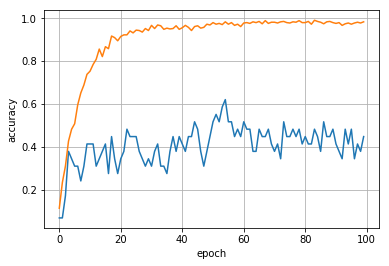

In [56]:
import pickle
model_his = 'save_models-5/AudioWords.npy'
data = pickle.load(open(model_his, 'rb'))
print(max(data['val_acc']))
plt.figure()
plt.plot(data['val_acc'])
plt.plot(data['acc'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
#plt.yscale('log')
plt.grid(True)

0.48275862377265405


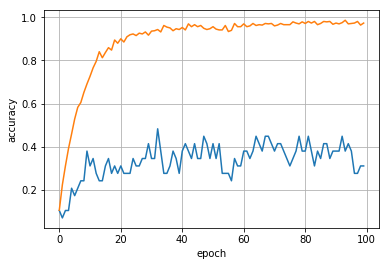

In [76]:
import pickle
model_his = 'save_models-4/AudioWords.npy'
data = pickle.load(open(model_his, 'rb'))
print(max(data['val_acc']))
plt.figure()
plt.plot(data['val_acc'])
plt.plot(data['acc'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
#plt.yscale('log')
plt.grid(True)